In [1]:
# data processing
import pandas as pd
from datetime import datetime

# visualization
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from adjustText import adjust_text
import colorsys

# computation
import numpy as np
import scipy.sparse as sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score

# utilities
from collections import Counter
from textblob import TextBlob # simple sentiment calculation

In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

# EDA for streamer info

Let's take a look at the streamer info we collected from Twitch Tracker.

In [2]:
df = pd.read_csv("data/streamer_info_eng.csv")
df.drop("language", axis=1, inplace=True) # we're only going to analyze english streamers

In [3]:
df.head()

,name,rec_hours_streamed,rec_avg_viewers,rec_peak_viewers,rec_hours_watched,rec_followers_gained,rec_followers_per_hour,rec_views_gained,rec_number_of_streams,total_hours_streamed,...,mature_content,channel_description,avg_games_streamed,avg_views_gained,avg_followers_gained,avg_stream_duration,active_days_per_week,unique_games_played,stream_start,total_activity
0,20k_wtt,267,362,2559,96768,179,0.67,125117,9,267,...,No,NaN,1.0,13900,20,20.6,7.0,1,09:50,13 of 13 days
1,2BCSuperb,86,1008,3710,86436,4671,54.50,94977,34,642,...,No,NHL 20 CONTENT - NHL HIGHLIGHTS - GAMING - 2BC...,1.2,2100,122,2.7,1.2,33,17:20,236 of 1434 days
2,360Chrism,745,486,1668,362491,2087,2.80,646368,88,8922,...,No,"Super Mario, Pokemon, Pikmin Streamer primaril...",2.2,6500,49,7.2,6.0,143,16:10,1234 of 1448 days
3,39daph,532,7188,44646,3829167,179466,337.00,4287705,77,4448,...,No,spawns at midnight (pst),1.9,20000,995,6.7,3.8,167,06:10,666 of 1227 days
4,4Conner,568,527,3974,299669,32863,57.80,584559,102,1499,...,Yes,1-0 against tyler1 in a 1v1,1.5,1500,84,4.1,2.3,78,00:00,366 of 1131 days


In [4]:
df.shape

(2028, 26)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    2028 non-null   object 
 1   rec_hours_streamed      2028 non-null   int64  
 2   rec_avg_viewers         2028 non-null   int64  
 3   rec_peak_viewers        2028 non-null   int64  
 4   rec_hours_watched       2028 non-null   int64  
 5   rec_followers_gained    2028 non-null   int64  
 6   rec_followers_per_hour  2028 non-null   float64
 7   rec_views_gained        2028 non-null   int64  
 8   rec_number_of_streams   2028 non-null   int64  
 9   total_hours_streamed    2028 non-null   int64  
 10  career_peak_viewers     2028 non-null   int64  
 11  total_followers         2028 non-null   int64  
 12  total_views             2028 non-null   int64  
 13  ranking                 2028 non-null   int64  
 14  creation_date           2028 non-null   

We can see there are a variety of datatypes: objects (strings & dates) and numeric columns (integer counts & float averages). Aside from channel description, there are no missing values.

Below we divide the columns into different categories: recent metrics, career metrics, average stream metrics, and miscellaneous.

In [6]:
rec_cols = ['rec_hours_streamed', 'rec_avg_viewers', 'rec_peak_viewers', 'rec_hours_watched', 'rec_followers_gained', \
            'rec_followers_per_hour', 'rec_views_gained', 'rec_number_of_streams']
career_cols = ['total_hours_streamed', 'career_peak_viewers', 'total_followers', 'total_views', 'unique_games_played', \
               'total_activity']
avg_cols = ['avg_games_streamed', 'avg_views_gained', 'avg_followers_gained', 'avg_stream_duration', 'active_days_per_week']
misc_cols = ['name', 'creation_date', 'stream_start', 'partnered', 'mature_content', 'channel_description']

## Recent metrics

In [8]:
rec_cols

['rec_hours_streamed',
 'rec_avg_viewers',
 'rec_peak_viewers',
 'rec_hours_watched',
 'rec_followers_gained',
 'rec_followers_per_hour',
 'rec_views_gained',
 'rec_number_of_streams']

Before looking at the distributions of these metrics, it's worth noting that many of these are likely to be highly correlated.

In [9]:
corr_mat = df[rec_cols].rename(columns={x:x.lstrip("rec_") for x in rec_cols}).corr() # get correlation matrix
corr_mat[np.tril(np.ones(corr_mat.shape)).astype(bool)] = np.nan # ignore lower diagonal because matrix is symmetric
corr_mat = pd.DataFrame(corr_mat.unstack().sort_values(ascending=False).reset_index()) # convert matrix to dataframe and sort by correlation
corr_mat = corr_mat[~corr_mat.isna().any(axis=1)] # ignore nan entries from two lines above
corr_mat = corr_mat.rename(columns={'level_0':"variable 1", "level_1":"variable 2",  0:"correlation"}) # rename for presentation
corr_mat

,variable 1,variable 2,correlation
0,peak_viewers,avg_viewers,0.723238
1,hours_watched,avg_viewers,0.694539
2,followers_gained,avg_viewers,0.685741
3,followers_per_hour,followers_gained,0.685575
4,hours_watched,peak_viewers,0.657392
5,views_gained,hours_watched,0.599059
6,followers_per_hour,avg_viewers,0.598450
7,followers_gained,peak_viewers,0.590417
8,followers_gained,hours_watched,0.554513
9,views_gained,peak_viewers,0.459916


For another view of these correlations, we fixate on average viewers and plot its correlation with all other variables below.

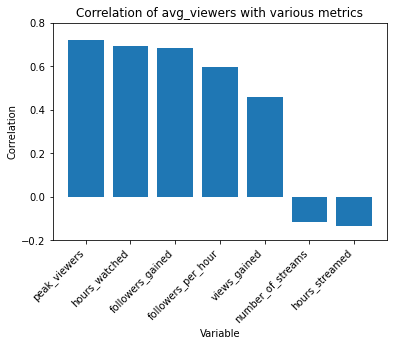

In [10]:
var2 = []
vals = []
for i in range(len(corr_mat)):
    if corr_mat["variable 1"].iloc[i] == "avg_viewers":
        var2.append(corr_mat["variable 2"].iloc[i])
    elif corr_mat["variable 2"].iloc[i] == "avg_viewers":
        var2.append(corr_mat["variable 1"].iloc[i])
    else:
        continue
    vals.append(corr_mat["correlation"].iloc[i])

plt.bar(var2, vals)
plt.xticks(rotation=45, ha="right")
plt.ylim([-0.2,0.8])
plt.title("Correlation of avg_viewers with various metrics")
plt.ylabel("Correlation")
plt.xlabel("Variable")
plt.show()

There are some suprising observations and some not-so-surprising observations. Not surprisingly, average viewers is highly correlated with almost all other metrics, with average viewers & peak viewers being the most correlated. Surprisingly, average viewers and number of streams are negatively correlated. Based on my knowledge of Twitch, this is likely due to "big events" and eSports channels like "Riot Games" and "ESL_CSGO" bringing in massive numbers of views when they do stream.

It is very surprising that followers_per_hour is negatively correlated with hours streamed. Perhaps this could be due to error of Twitch Tracker not being able to correctly track these shorter streams. Otherwise, this is an interesting result -- suggesting that followers per hour trail off as stream length increases. These diminishing returns could be worth considering for streamers that are trying to grow their channel.

We now look at the distributions of these metrics. All histograms are plotted with a log scale x-axis. Note: there are a few (a negligible amount of) negative values for followers_per_hour which are hard to show on a log-scale so we omit these.

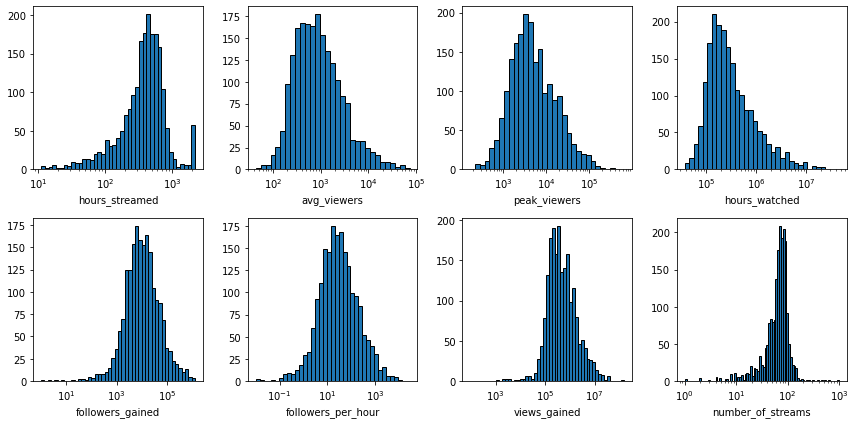

In [82]:
fig, ax = plt.subplots(2,4, figsize=(12,6))
ax = ax.flatten()
for i in range(len(rec_cols)):
    plt.sca(ax[i])
    data = df.loc[df[rec_cols[i]] > 0, rec_cols[i]].values
    _, bins = np.histogram(np.log10(data), bins='auto')
    plt.hist(data, bins=10**bins, edgecolor="black")
    plt.xlabel(rec_cols[i].lstrip("rec_"))
    plt.xscale("log")

plt.tight_layout()
plt.show()

Several of the distributions look normally distributed on a log-scale (i.e. they seem to follow a log-normal distribution). Number of streams is very sharp peaked at around 60-70 streams (in the last 3 months). This is an average of about 5 streams per week. There are some outliers having nearly 1000 streams in the last 3 months, i.e. restarting their stream 100 times per day (why?!? this is unlikely to be good content with this many interruptions). Furthermore, we see hour_streamed peaks at around 400 hours in the last 3 months. Thus, a typical stream is approx. $400/60=6.6$ hours. We provide a more accurate calculation of this below.

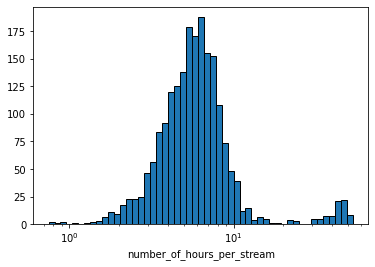

In [81]:
data = df["rec_hours_streamed"].div(df["rec_number_of_streams"])
data = data.values
_, bins = np.histogram(np.log10(data), bins='auto')
plt.hist(data, bins=10**bins, edgecolor="black")
plt.xlabel("number_of_hours_per_stream")
plt.xscale('log')
plt.show()

In [61]:
print("The peak number_of_hours_per_stream is approx.", np.mean(10**bins[[cts.argmax()-1,cts.argmax()]]))

The peak number_of_hours_per_stream is approx. 6.576149184841873


The top 2k streamers typically stream 5 days a week for 6.5 hours/day. That is, they treat it very much like a normal job.

## Career metrics

In [48]:
df[career_cols].head()

,total_hours_streamed,career_peak_viewers,total_followers,total_views,unique_games_played,total_activity
0,267,2559,182,127359,1,13 of 13 days
1,642,3710,53531,684928,33,236 of 1434 days
2,8922,8626,116402,11540387,143,1234 of 1448 days
3,4448,44646,653858,13108514,167,666 of 1227 days
4,1499,3974,35469,638760,78,366 of 1131 days


We need to convert total activity to a numeric dtype. We will convert this to a percentage of total days tracked (i.e. 13 of 13 becomes 100%).

In [49]:
df["total_activity"] = df["total_activity"].apply(lambda x: 1.0 * int(x.split()[0])/int(x.split()[2]))

In [52]:
df[career_cols].head()

,total_hours_streamed,career_peak_viewers,total_followers,total_views,unique_games_played,total_activity
0,267,2559,182,127359,1,1.000000
1,642,3710,53531,684928,33,0.164575
2,8922,8626,116402,11540387,143,0.852210
3,4448,44646,653858,13108514,167,0.542787
4,1499,3974,35469,638760,78,0.323607


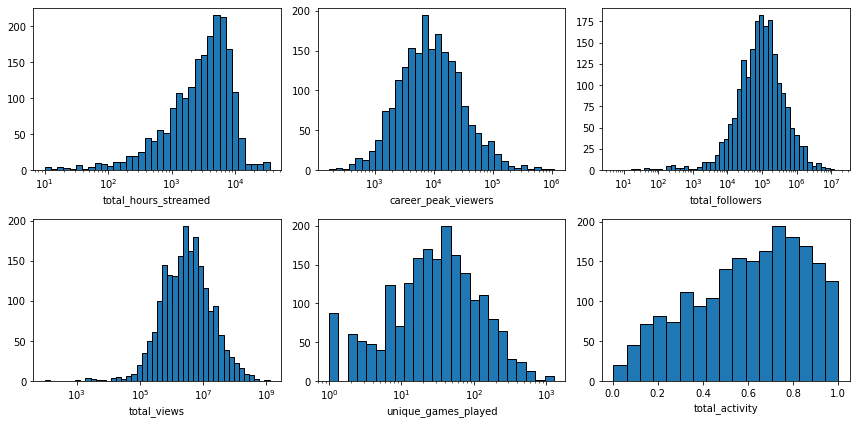

In [80]:
fig, ax = plt.subplots(2,3, figsize=(12,6))
ax = ax.flatten()
for i in range(len(career_cols)):
    plt.sca(ax[i])
    if career_cols[i] == "total_activity":
        plt.hist(df[career_cols[i]], bins="auto", edgecolor="black") # not log scale
    else:
        data = df.loc[df[career_cols[i]] > 0, career_cols[i]].values
        _, bins = np.histogram(np.log10(data), bins='auto')
        plt.hist(data, bins=10**bins, edgecolor="black")
        plt.xscale("log")
        
    plt.xlabel(career_cols[i])
    
plt.tight_layout()
plt.show()

In [66]:
print("Career metrics: median values")
df[career_cols].median()

Career metrics: median values


total_hours_streamed    3.368500e+03
career_peak_viewers     8.400000e+03
total_followers         9.292000e+04
total_views             2.993105e+06
unique_games_played     3.000000e+01
total_activity          6.340956e-01
dtype: float64

In the top 2k streamers, we see typical performance metrics are: 
- total_hours_streamed = 3k
- career_peak_viewers = 8.4k
- total_followers = 92k
- total_views = 3m
- unique_games_played = 30
- total_activity = 63%

It is interesting to see that most streamers have streamed 30+ games, considering they usually focus on 1-2 "main games."

## Average stream metrics

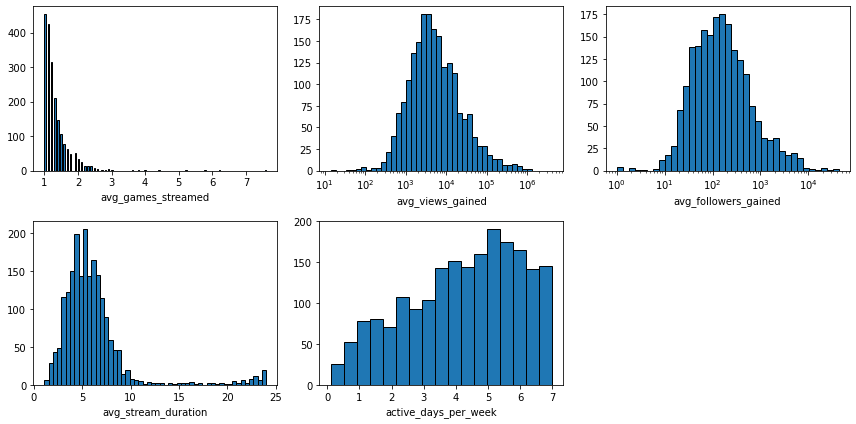

In [86]:
fig, ax = plt.subplots(2,3, figsize=(12,6))
ax = ax.flatten()
for i in range(len(avg_cols)):
    plt.sca(ax[i])
    data = df.loc[df[avg_cols[i]] > 0, avg_cols[i]].values
    if avg_cols[i] == "avg_games_streamed":
        data = data[data < 10] # one outlier > 10, remove for plotting purposes
    
    if avg_cols[i] in ["avg_games_streamed", "avg_stream_duration", "active_days_per_week"]:
        plt.hist(data, bins="auto", edgecolor="black") # not log scale
        
    else:
        _, bins = np.histogram(np.log10(data), bins="auto")
        plt.hist(data, bins=10**bins, edgecolor="black")
        plt.xscale("log")
        
    plt.xlabel(avg_cols[i])

ax[5].set_visible(False)
plt.tight_layout()
plt.show()

An average stream only features 1 game, while occasionally some feature 2, 3, or even more. Around 200 followers are gained on each stream. Again we see most common stream duration is ~6 hours and active days per week is ~5 days.

## Miscellaneous data

In [90]:
df[misc_cols].head()

,name,creation_date,stream_start,partnered,mature_content,channel_description
0,20k_wtt,2020-10-23,09:50,No,No,NaN
1,2BCSuperb,2013-12-16,17:20,Yes,No,NHL 20 CONTENT - NHL HIGHLIGHTS - GAMING - 2BC...
2,360Chrism,2012-11-18,16:10,Yes,No,"Super Mario, Pokemon, Pikmin Streamer primaril..."
3,39daph,2017-06-17,06:10,Yes,No,spawns at midnight (pst)
4,4Conner,2016-03-23,00:00,No,Yes,1-0 against tyler1 in a 1v1


Let's take a look at the binary columns: partnered and mature_content. A streamer is partnered essentially if they make money from Twitch (i.e. they earn a share of the ads and they have a subscribe button). Generally top streamers are offered partnership. Mature content is a flag that streamers can opt to put on their channel mainly to warn younger audiences. Since it is optional, streams with "mature_content==No" may still contain mature content.

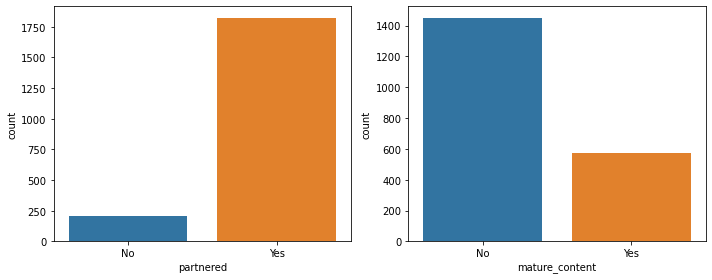

In [95]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
plt.sca(ax[0])
sns.countplot(x="partnered", data=df)
plt.sca(ax[1])
sns.countplot(x="mature_content", data=df)
plt.tight_layout()
plt.show()

Of the top 2k streamers, over 1.7k are partnered while 250 are not partnered. A good amount (600) have a mature content flag on their channel. How do these groups differ in popularity?

In [117]:
df[["partnered", "rec_hours_watched","total_followers"]].groupby("partnered").mean()

,rec_hours_watched,total_followers
partnered,,
No,329897.812808,57196.970443
Yes,804550.501370,288794.769315


In [118]:
df[["mature_content", "rec_hours_watched","total_followers"]].groupby("mature_content").mean()

,rec_hours_watched,total_followers
mature_content,,
No,805163.020661,291233.215565
Yes,635724.331597,201025.711806


As expected, partnered streamers are more popular -- according to both recent hours watched and total followers -- than unpartnered streamers. Partnership appears to multiply hours watched by over 2x, whereas total followers are increased by 6x. Streams without the mature content flag tend to be slightly more popular; however, it's unclear whether this is causative.

Let's take a look at the two date/time columns: creation_date and stream_start.

In [151]:
# group creation date by [year,month] and get counts by using .size() method
df_date = pd.DataFrame(pd.to_datetime(df["creation_date"])).set_index("creation_date")
gp_counts = df_date.groupby(by=[df_date.index.year, df_date.index.month]).size()
df_gp_counts = pd.DataFrame(gp_counts).rename(columns={0:"counts"})
df_gp_counts

counts
creation_date creation_date        
2007          5                   4
              6                   1
              7                   1
              8                   1
              10                  1
...                             ...
2020          6                  10
              7                  16
              8                  11
              9                  10
              10                 10

[156 rows x 1 columns]

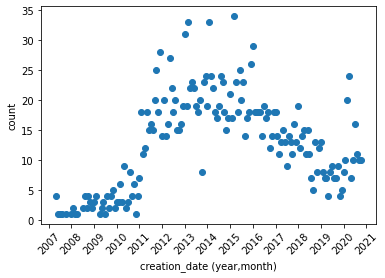

In [207]:
# plot the table above
x_dates = [datetime(year=x[0], month=x[1], day=1) for x in df_gp_counts.index]
x_dates = [mdates.date2num(x) for x in x_dates]
plt.scatter(x=x_dates, y=df_gp_counts["counts"].values)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.xlabel("creation_date (year,month)")
plt.ylabel("count")
plt.show()

Most of the channels that are popular today were created in 2013-2014. Some channels were created before Twitch formally existed (2011 and prior). Twitch was initially Justin TV, which began in 2006.  

Note: the decrease in creation_date since 2014 does not imply Twitch is decreasing in popularity, rather just that it takes time to become popular.

Let's take a look at stream start timing.

In [313]:
df_date = df[df["stream_start"] != "Invalid date"]
df_date = pd.DataFrame(pd.to_datetime(df_date["stream_start"], format="%H:%M")).set_index("stream_start")
gp_counts = df_date.groupby(by=df_date.index.hour).size()
df_gp_counts = pd.DataFrame(gp_counts).rename(columns={0:"counts"})
df_gp_counts.head()

,counts
stream_start,
0,282
1,18
2,36
3,55
4,46


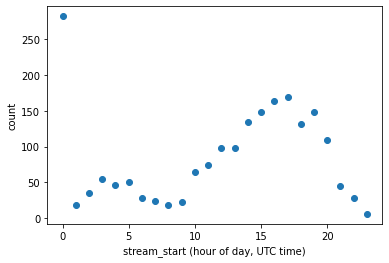

In [319]:
plt.scatter(x=df_gp_counts.index, y=df_gp_counts["counts"])
plt.xlabel("stream_start (hour of day, UTC time)")
plt.ylabel("count")
plt.show()

Twitch Tracker uses UTC time which is 5 hours ahead of EST.

There seems to be a rather clear bimodal trend, aside from the point at midnight UTC (7pm EST) which may be an error of Twitch Tracker. There's a small peak at 3am UTC (10pm EST) and a larger peak at 5pm UTC (noon EST). There are very few streamers starting at 8am UTC (3am EST) which makes sense considering the U.S., the largest demographic for Twitch viewers, is sleeping.

One question worth asking is, what is the optimal time to stream?

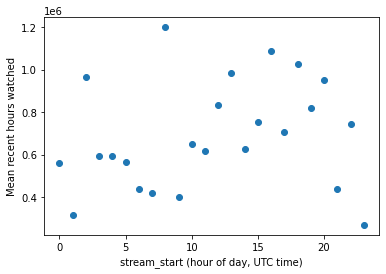

In [363]:
df_date = df.loc[df["stream_start"] != "Invalid date", ["stream_start", "rec_hours_watched"]]
df_date["stream_start"] = pd.to_datetime(df_date["stream_start"], format="%H:%M")
df_date = df_date.set_index("stream_start")
gp_counts = df_date.groupby(by=df_date.index.hour)
gp_counts = gp_counts.agg(mean_hours=("rec_hours_watched", "mean"))

plt.scatter(x=gp_counts.index, y=gp_counts["mean_hours"])
plt.xlabel("stream_start (hour of day, UTC time)")
plt.ylabel("Mean recent hours watched")
plt.show()

While we can see the outline of the trend from the previous plot, it is a much noisier plot. The weak association between the two plots suggests that streaming at common start times is connected with user reception. In other words, streamers have figured out *efficient* times to start streaming. Perhaps starting at an outlier time like 2am UTC could fill a gap where nobody is live yet average reception is good -- but again this is a noisy plot and thus this is a risky strategy.

Lastly, let's look at channel description. From my knowledge, these are usually missing, not informative at all, or may contain jokes/sarcasm/memes. Thus, I don't expect them to be very useful but we'll check it out.

In [323]:
with pd.option_context('display.max_colwidth', None):
    display( df.sort_values("rec_hours_watched", ascending=False)[["name", "channel_description"]].head(8) )

,name,channel_description
1964,xQcOW,Overwatch Professional tank player and full time streamer. EZ Clap
1467,Riot Games,"Welcome to the Riot Games channel, home of LoL Esports and other livestreams related to our games. For LoL Esports broadcasts, schedules, standings and advanced viewing features, head to http://lolesports.com."
566,ESL_CSGO,Get all your world-class ESL Counter-Strike here!! All premium live content and 24/7 re-runs!!
1245,NICKMERCS,"Former MLG National Champion. A fellow gym rat, who streams mostly Competitive Shooters! Thank you all so much for your continued support. Follow the stream and my Twitter account to be notified when I will be going live - @Nickmercs"
1043,loltyler1,Season 6 Challenger | Most REFORMED Player NA | #1 Draven World
1620,sodapoppin,"Wtf do i write here? Click my stream, or i scream."
1788,TimTheTatman,"Gamer, nerd, geek. Streaming mostly FPS/Whatevs/Yolo. Feel welcomed, talk to me, and be yourself. Welcome to the #tatmanarmy, one of the most interactive communities on twitch!"
1566,shroud,I'm back baby


This one sums up the usefulness of channel descriptions.

> Wtf do i write here? Click my stream, or i scream

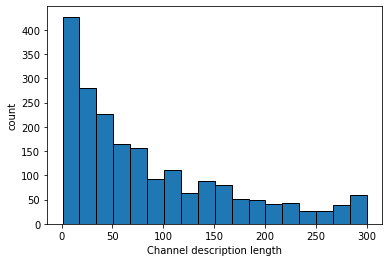

In [269]:
plt.hist(df["channel_description"].apply(lambda x: len(str(x))), bins="auto", edgecolor="black")
plt.xlabel("Channel description length")
plt.ylabel("count")
plt.show()

We see channel descriptions are generally very short or nonexistent -- with a maximum character count of 300. 

Just for fun: Is there any correlation between description length or description sentiment and popularity?

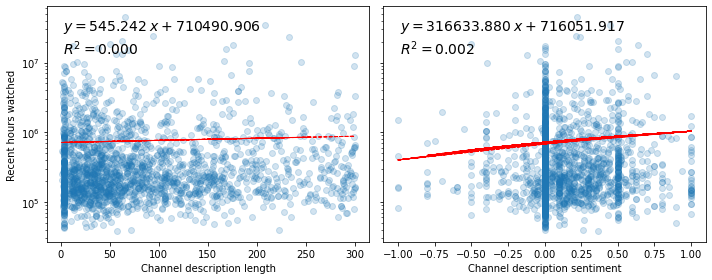

In [290]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
a = 0.2
y = df["rec_hours_watched"]

# 1. Channel description length
plt.sca(ax[0])
x = df["channel_description"].apply(lambda x: len(str(x)))
plt.scatter(x, y, alpha=a)
plt.xlabel("Channel description length")
plt.ylabel(r"Recent hours watched")
plt.yscale("log")

# trend
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.text(0.05, 0.95, text,transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# 2. Channel description sentiment
plt.sca(ax[1])
x = df["channel_description"].apply(lambda x: TextBlob(str(x).lower()).sentiment.polarity)
plt.scatter(x, y, alpha=a)
plt.xlabel("Channel description sentiment")

# trend
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.text(0.05, 0.95, text,transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()

Not much to see here, as expected. There is no association between channel description and popularity. Channel description sentiment is usually neutral, likely because most words are not actually words/are not included in the TextBlob corpora. 

# Network analysis

Here our goal is to understand the "landscape" of Twitch by building and analyzing a network of streamers.

In [3]:
df = pd.read_csv("data/user_follows-2.csv")

## Calculating main game
An important characterization of streamers is the list of games they play. We will use this to label our network. Below we process the `games/` data and determine the **most played game** for each streamer.

In [4]:
games = {}
for streamer in df["streamer_name"].unique():
    gamefile = "data/games/%s.csv" % streamer
    df_game = pd.read_csv(gamefile) 
    df_game = df_game[~df_game.isna().any(axis=1)]
    if len(df_game) == 0:
        games[streamer] = "Other"
    else:
        df_game.loc[df_game["Game"]=="Unknown", "Game"] = "Other" # relabel "Unknown" --> "Other"
        df_game.loc[df_game["Game"]=="IRL", "Game"] = "Just Chatting" # Just Chatting used to be called IRL
        
        # we found these two games to both rank within the top10/top20, but they are essentially the same
        # so we'll recode these as "Call of Duty"
        df_game.loc[df_game["Game"].isin(["Call of Duty: Black Ops 4", "Call Of Duty: Modern Warfare"]), "Game"] = "Call of Duty"
        
        # Calculate percent airtime
        # There is something weird in the Twitch Tracker data where the same game can appear multiple times in the
        # "top 10 games" table. To fix this, we groupby game title and sum airtime
        df_game["pct_airtime"] = df_game["Total airtime"].apply(lambda x: x.split("hrs")[1].strip("%")).astype('float').values
        df_gp = df_game[["Game","pct_airtime"]].groupby("Game")
        main_game = df_gp.sum().reset_index().sort_values("pct_airtime", ascending=False).head(1)["Game"].values[0]

        # record main game
        games[streamer] = main_game

In [5]:
counter = Counter([x for x in list(games.values()) if x != "Other"])

n = 10 # top 10 games
print("Top %i games:\n" % n)
print(counter.most_common(n))

Top 10 games:

[('Just Chatting', 200), ('Fortnite', 162), ('League of Legends', 107), ('Call of Duty', 91), ('World of Warcraft', 82), ('Grand Theft Auto V', 77), ('Overwatch', 53), ('Minecraft', 52), ('Apex Legends', 45), ('Counter-Strike: Global Offensive', 44)]


In [6]:
# extract just the names
top_games = [name for name,count in counter.most_common(n-1)] + ["Other"]
top_games

['Just Chatting',
 'Fortnite',
 'League of Legends',
 'Call of Duty',
 'World of Warcraft',
 'Grand Theft Auto V',
 'Overwatch',
 'Minecraft',
 'Apex Legends',
 'Other']

In [7]:
# recode games dictionary so that any streamer who doesn't play one of the top n-1 games is said to play "Other"
print("Number of unique games before:", len(set(games.values())))
games = {x:(games[x] if games[x] in top_games else "Other") for x in games}
print("Number of unique games after (should be %i):" % n, len(set(games.values())))

Number of unique games before: 215
Number of unique games after (should be 10): 10


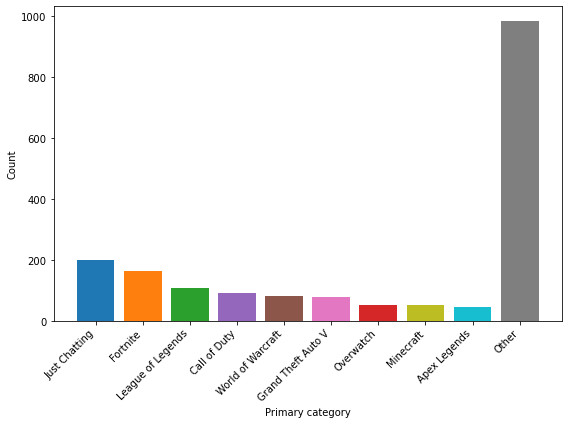

In [10]:
# plotting counts
plt.figure(figsize=(8,6))
colors = ['tab:' + x for x in ['blue', 'orange', 'green', 'purple', 'brown', 'pink', 'red', 'olive', 'cyan', 'gray']]
other_sum = sum(count for name,count in counter.most_common()[n:]) # sum of counts for all other games
plt.bar(x=top_games, height=[count for name,count in counter.most_common(n-1)]+[other_sum], color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Primary category")
plt.ylabel("Count")
plt.tight_layout() # helps keep .png from getting cut off
plt.savefig("figures/top_games.png")
plt.show()

The most common "main game" is Just Chatting, followed closely by Fortnite, League of Legends, and Call of Duty. We see there is a large diversity of main games; with 1000 (50%) of them not being present in the top 9.

## Building the network

Now we build the network from the user_follows data. First we load in the data, encode names as IDs, and convert to a sparse user-items matrix.

In [8]:
# lookup ID corresponding to streamer name or vice versa -- this will be helpful for examining individual recommendations
encode_streamer = {x:y for x,y in zip(df["streamer_name"], df["streamer_name"].astype("category").cat.codes)}
decode_streamer = {y:x for x,y in zip(df["streamer_name"], df["streamer_name"].astype("category").cat.codes)}

# user_ID is already an integer, but we need to convert it to the range [0,n_users). We can do this by converting to categorical
# and then using an ordinal encoder (cat.codes). streamer_name can be dealt with in the same way.
df["user_ID"] = df["user_ID"].astype("category").cat.codes
df["streamer_name"] = df["streamer_name"].astype("category").cat.codes

# We'll use the 3rd column as the value in the interaction matrix
# By setting it to 1 we're saying the values in the interaction matrix are in {0,1}
# It might be worth weighting this value by the time followed at (older/newer follows more predictive of "liking" the streamer?)
df["followed_at"] = 1

# rename columns
df.rename(columns={"streamer_name":"streamer_ID", "followed_at":"weight"}, inplace=True)

# convert dataframe to sparse matrix
user_items = sparse.csr_matrix( (df["weight"], (df['user_ID'], df['streamer_ID'])) ) # format for fitting is (item,user)

Now we will assign a similarity score between each pair of streamers. We do this using the cosine similarity of each pair of streamers' item vectors $y_i, y_j$. Cosine similarity has a nice interpretation here since our vectors are binary 0,1's.

$$sim(y_i, y_j) \equiv \frac{y_i^T y_j}{\lVert y_i \rVert \lVert y_j \rVert} = \frac{\# \text{shared followers} }{\# \text{$i$'s followers} \cdot \# \text{$j$'s followers}}.$$ 

The denominator penalizes the number of shared followers by the total number of followers. For example, if $i$ and $j$ have $1000$ shared followers, knowing $i$ only has $1000$ total followers suggests higher similarity to $j$ than if $i$ had $1,000,000$ followers.

In [9]:
cs = cosine_similarity(user_items.T, user_items.T) # get n_item x n_item matrix of item similarities
cs[np.tril(np.ones((cs.shape[0],cs.shape[1]))).astype(bool)] = 0 # since matrix is symmetric, set lower diagonal to zero
                                                                # this also helps to remove self-loops
cs.shape

(1904, 1904)

In [10]:
possible_nonzero = cs.shape[0]*(cs.shape[0]-1)/2 # n choose 2 possible nonzero edges
print("Number of nonzero entries", np.sum(cs > 0))
print("Sparsity:", np.sum(cs > 0)/possible_nonzero) # sparsity

Number of nonzero entries 961397
Sparsity: 0.5306730416812022


This is very dense, if we try to plot this network there will be a huge number of edges and it'll look like a mess. We need to set a threshold and filter out some edges.

In [11]:
p = np.percentile(cs[cs > 0], 99.65)
cs[cs < p] = 0
print("New number of nonzero entries", np.sum(cs > 0))

New number of nonzero entries 3365


Now we translate our adjacency matrix to a networkx graph and relabel nodes with streamer names. Since the resulting network is not connected, we get only the giant component.

In [12]:
def get_giant_component(G, print_info=False):
    # extract only the giant component
    cc = sorted(nx.connected_components(G), key=len, reverse=True)
    
    if print_info:
        print("Number of components:", len(cc))
        print("Top 10 component sizes:", [len(c) for c in cc][:10])
        print("Number of nodes in giant component:", len(cc[0]))
    G.remove_nodes_from(set(G.nodes()) - set(cc[0]))
    
    return G

G = nx.from_numpy_matrix(cs, create_using=nx.Graph)
G = nx.relabel_nodes(G, decode_streamer)
G = get_giant_component(G, print_info=True) # get connected component

Number of components: 1001
Top 10 component sizes: [369, 52, 34, 33, 23, 22, 21, 18, 18, 17]
Number of nodes in giant component: 369


We see of the 2k streamers, only 369 remain in the largest component. It might be worth looking at plots of the smaller components (i.e. the one with 52 nodes), but we'll focus on the largest.

In [13]:
# which "top games" are represented now that there are fewer streamers?
top_games_represented = set([games[streamer] for streamer in G.nodes()])
top_games_represented = [x for x in top_games if x in top_games_represented] # restore ordering according to Counter
print("Number of games:", len(top_games_represented))

Number of games: 10


## Preparing the visualization

In [31]:
# PARAMETERS
metric = "rec_hours_watched" # metric by which node sizes are calculated and some select nodes are labelled
n_streamers = 2 # number of streamers to label (per game)
node_size_scale = 10**4.2 # how much to magnify all nodes
fs = 14 # figsize will be (fs x fs)
outer_size_ratio = 1.08 # make this larger to make the outer ring bigger. must be > 1.
inner_lightness_ratio = 1.15 # make this larger to make the inner ring brighter
edge_width = 0.25 # edge width
edge_alpha = 0.5 # edge alpha
lgnd_nsz = 200 # size of node in legend
font_size = 28 # font size for labels
k = 0.4 # spring_layout parameter. make k larger to push nodes further apart
r = np.random.RandomState(123) # random state for spring layout

In [32]:
df_info = pd.read_csv("data/streamer_info.csv")
df_info = df_info[df_info["name"].isin(list(G.nodes()))]

# NODE SIZES
# size nodes according to recent hours watched
node_sizes = {x:y/node_size_scale for x,y in zip(df_info["name"], df_info[metric])}

# NODE LABELS
# label a few select streamers (top n_streamers) 
df_info["main_game"] = df_info["name"].map(games)
biggest_streamers = df_info.groupby("main_game").apply(lambda grp: grp.nlargest(n_streamers, metric))["name"].values
node_labels = {x:x for x in biggest_streamers}
node_labels.update({x:"" for x in df_info["name"].values if x not in biggest_streamers})

# NODE COLORS
# base colors
colors = ['tab:' + x for x in ['blue', 'orange', 'green', 'purple', 'brown', 'pink', 'red', 'olive', 'cyan', 'gray']]
# function for plot cosmetics -- makes node color brighter/darker acccording to parameter scale_l
def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return np.array( colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s) ).reshape(1,-1)

# NETWORK LAYOUT
pos = nx.spring_layout(G, k=k, seed=r)

## Visualization

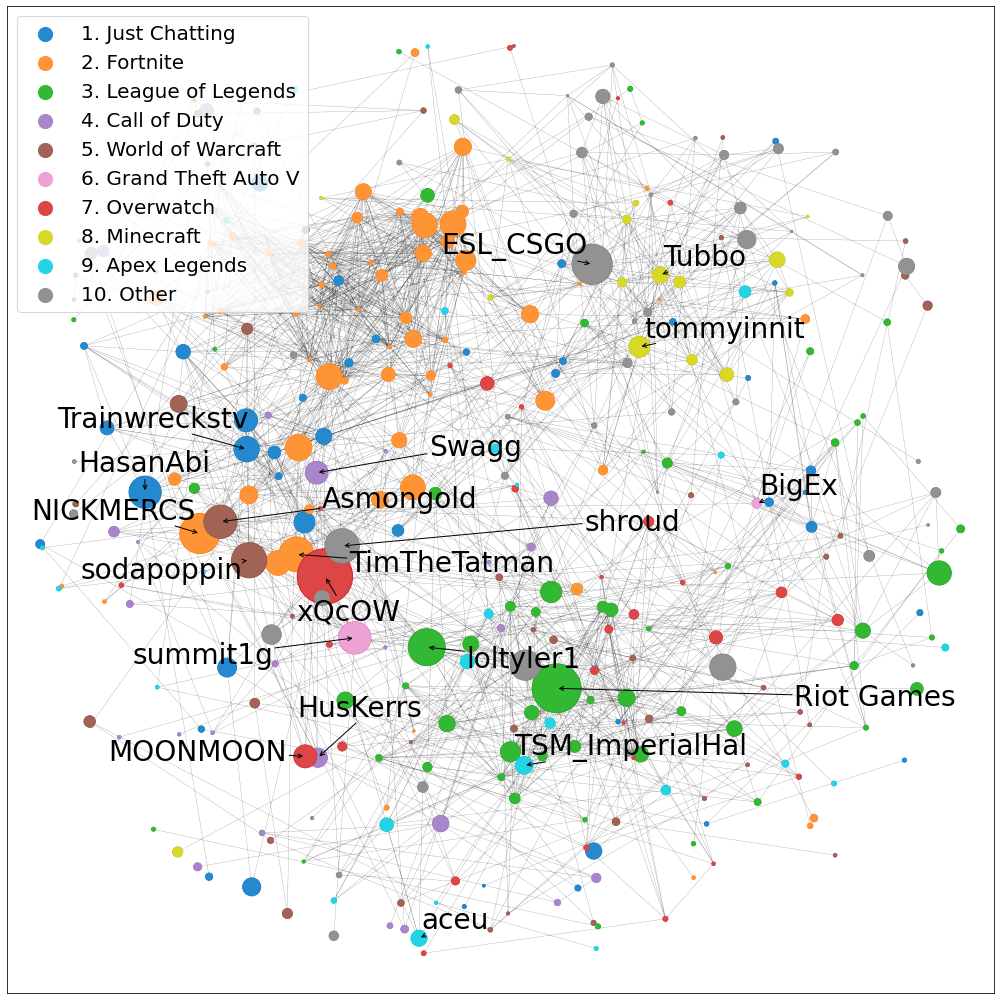

In [33]:
plt.figure(figsize=(fs,fs))
for i,game in enumerate(top_games_represented):
    nodelist = [x for x in G.nodes() if games[x] == game]
    nlb = list(map(lambda x: node_labels[x], nodelist))
    nsz = list(map(lambda x: node_sizes[x], nodelist))
    
    # Draw nodes twice for cosmetic purposes  
    # 1. Draw node once (outer ring)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodelist, node_size=np.array(nsz)*outer_size_ratio, node_color=colors[i])
    # 2. Draw node again (inner ring, lighter color) 
    sl = scale_lightness( matplotlib.colors.ColorConverter.to_rgb(colors[i]), inner_lightness_ratio)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodelist, node_size=nsz, node_color=sl, label="%i. %s" % (i+1,game) )
    
# nx.draw_networkx_labels(G, pos=pos, labels=node_labels, font_color="black", font_weight="bold", font_size=18)

# Draw edges
nx.draw_networkx_edges(G,pos=pos,width=edge_width, alpha=edge_alpha)   

# legend
lgnd = plt.legend(scatterpoints = 1, prop={'size': 20}, loc="upper left")
for i in range(len(top_games_represented)):
    lgnd.legendHandles[i]._sizes = [lgnd_nsz]

# labels and label positioning
texts = [plt.text(pos[x][0], pos[x][1], node_labels[x], size=font_size) for x in pos if node_labels[x] != '']
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black')) # adjust text

plt.axis('equal') 
plt.tight_layout()
plt.savefig('figures/network.png')
plt.show()

We see the dominance of the top 3 games: Just Chatting, Fortnite, and League of Legends. Fortnite streamers are very densely connected among themselves (according to cosine similarity) and relatively disconnected from the rest of the streamers, meaning that Fortnite streamers attract a common, exclusive audience. This is also seems to be true for Minecraft, but to a lesser extent. Fortnite and Minecraft are associated with younger audiences, which might suggest that younger Twitch users are more likely to only follow Fortnite/Minecraft streamers exclusively and not branch out. League of Legends is a more spread out community -- which perhaps is a result of it being a more competitive game and attracting older audiences. 

The left hand side sees several high profile streamers along with more diversity in games played: Just Chatting, Overwatch, World of Warcraft, Grand Theft Auto V, and Other. These streamers are often referred to as "variety streamers" and they set trends in which games are played. We see xQcOW is dominant in recent hours watched.

Towards the bottom we see the few Apex Legends players that made it into the network. Some of them are connected with League of Legends streamers.

## Conclusion
Apart from just understanding the Twitch landscape, these observations could be useful for both Twitch and its streamers. Here are a few possible "applications": (1) recommendations for Fortnite and Minecraft viewers are likely to be well-received if they are other Fortnite/Minecraft streamers (2) recommendations based on game genres are likely to be well-received (3) "variety streamers" (as defined above) have themselves built a niche which is game-independent; collaborations between these select streamers may be well-received (4) small streamers on the outskirts should (i) consider their choice of game (ii) "network their way" into a denser region of the network.